In [23]:
# ==============================
# Imports
# ==============================

# Manipulation des données
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# EDA automatisé
from ydata_profiling import ProfileReport

# Analyse temporelle
from statsmodels.tsa.seasonal import seasonal_decompose

# Préparation des données & ML pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

# Évaluation des modèles
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, make_scorer

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor, DMatrix, train

# Tuning
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

# Model artifacts
import joblib

import warnings

# Exploration des données (EDA)

Dans cette section, j'explore rapidement le dataset afin d'identifier :

- Le volume du dataset
- Les types des colonnes
- Les valeurs manquantes  
- La cardinalité des features

Ces étapes me permettent d’avoir une compréhension globale des données.

In [2]:
# Chargement des données
df = pd.read_csv("../data/raw/stores_sales_forecasting.csv", encoding="latin1")

print("Shape :", df.shape)
print("\nTypes de colonnes :")
print(df.dtypes)

print("\nValeurs manquantes par colonne :")
print(df.isna().sum())

print("\nValeurs uniques par colonne :")
print(df.nunique().sort_values(ascending=False))

Shape : (2121, 21)

Types de colonnes :
Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object

Valeurs manquantes par colonne :
Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit 

### Constat
- Dataset petit (2121 lignes et 21 colonnes). Dans un contexte réel, on chercherait à collecter plus de données ou utiliser des techniques d'augmentation. Dans ce cas-ci, je me contente du dataset actuel.

- `Country`, `Category`, `Row ID` et `Order ID` sont quasi uniques et n’apportent aucune information discriminante pour le modèle.

- `Quantity` peut causer du data leakage car c'est une donnée disponible uniquement après la vente et est directement lié à la vente, alors je vais l'exclure des features.

- `Costumer ID` et `Costumer Name` sont redondants, alors je vais garder seulement `Costumer ID`

- `Product ID` et `Product Name` sont redondants, alors je vais garder seulement `Product ID`

- `Postal Code` est iutile car trop granulaire considérant et on a déjà `City`, `State`, `Region` dans le dataset

### Prochaine étape

- Laisser tomber `Country`, `Category`,`Row ID`, `Order ID`, `Quantity`, `Costumer Name`, `Product Name`, `Postal Code`

- Je remarque qu'il y a une colonne `Profit`. D'un point de vue business, prévoir les ventes, tel que le mandat le définit, est utile. Par contre, si les ventes n'entrainent pas des profits, les dirigeants aimeraient assurément le savoir. Je vais donc vérifier la distribution des profits et possiblement faire un modèle en deux étapes si certaines ventes entrainent des pertes.

Dans un contexte réel, certaines ventes non rentables peuvent être des décisions d’affaires stratégiques (fidélisation, liquidation de stock, pénétration de marché). Cependant, dans le cadre de ce mandat, je fais l’hypothèse simplificatrice que ces transactions sont indésirables et qu’il est pertinent de les identifier afin de maximiser la profitabilité globale.

In [3]:
# Supprimer les colonnes non pertinentes ou sujettes au data leakage
cols_to_drop = [
    "Country",        # constant
    "Category",       # constant
    "Row ID",         # inutile
    "Order ID",       # inutile
    "Quantity",       # risque de data leakage
    "Customer Name",  # redondant avec customer ID
    "Product Name",   # redondant avec Product ID
    "Postal Code"     # trop granulaire
]

print("Colonnes supprimées :", cols_to_drop)

df = df.drop(columns=cols_to_drop)

Colonnes supprimées : ['Country', 'Category', 'Row ID', 'Order ID', 'Quantity', 'Customer Name', 'Product Name', 'Postal Code']


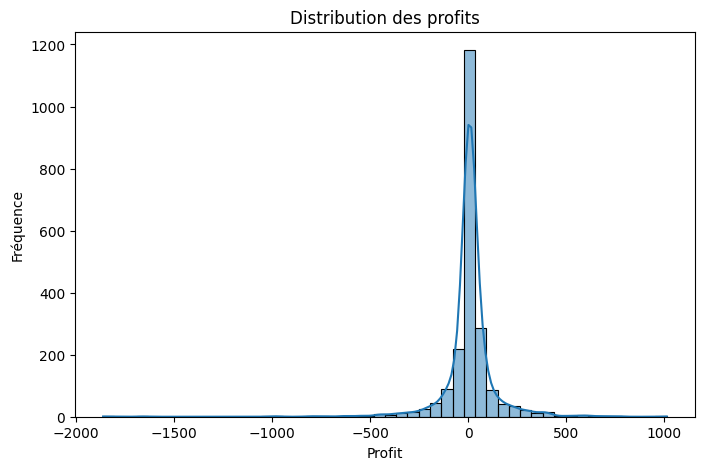

is_profitable
1    0.647808
0    0.352192
Name: proportion, dtype: float64


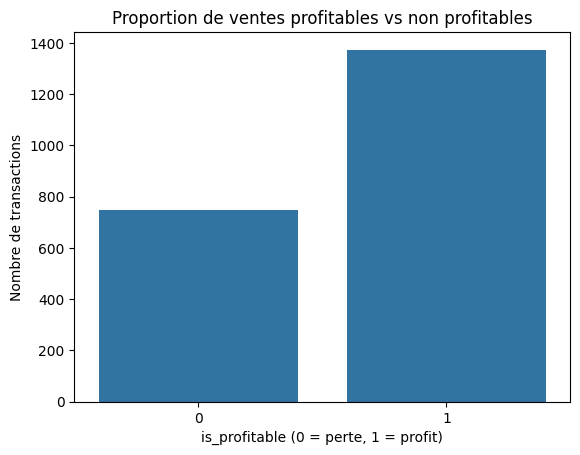

In [4]:
# Distribution des profits
plt.figure(figsize=(8,5))
sns.histplot(df['Profit'], bins=50, kde=True)
plt.title("Distribution des profits")
plt.xlabel("Profit")
plt.ylabel("Fréquence")
plt.show()

# Répartition ventes profitables vs non profitables
df['is_profitable'] = (df['Profit'] > 0).astype(int)
print(df['is_profitable'].value_counts(normalize=True))

sns.countplot(x='is_profitable', data=df)
plt.title("Proportion de ventes profitables vs non profitables")
plt.xlabel("is_profitable (0 = perte, 1 = profit)")
plt.ylabel("Nombre de transactions")
plt.show()

### Constat

- Plusieurs ventes ne génèrent pas de profit. Je choisis de prédire d’abord la profitabilité car des ventes non profitables sont non souhaitables. Ensuite, sur les ventes profitables uniquement, je vais prévoir leur montant.

### Décision d'orientation
- Je vais donc opter pour un modèle en deux étapes:
    - Classification: Pour prédire la profitabilité d'une commande
    - Régression conditionnelle: Pour prédire le montant des ventes seulement pour les transactions profitables

### Prochaines étapes

- Produire un rapport EDA exhaustif pour explorer les distributions, corrélations et valeurs manquantes.
- Produire la distribution générale des ventes.
- Vérifier la saisonnalité des données.

Export report to file: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 259.13it/s]


✅ Rapport complet généré : ../reports/eda_report.html


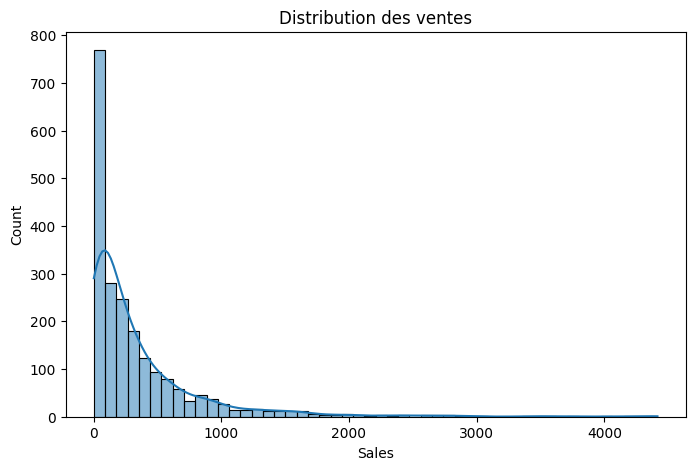

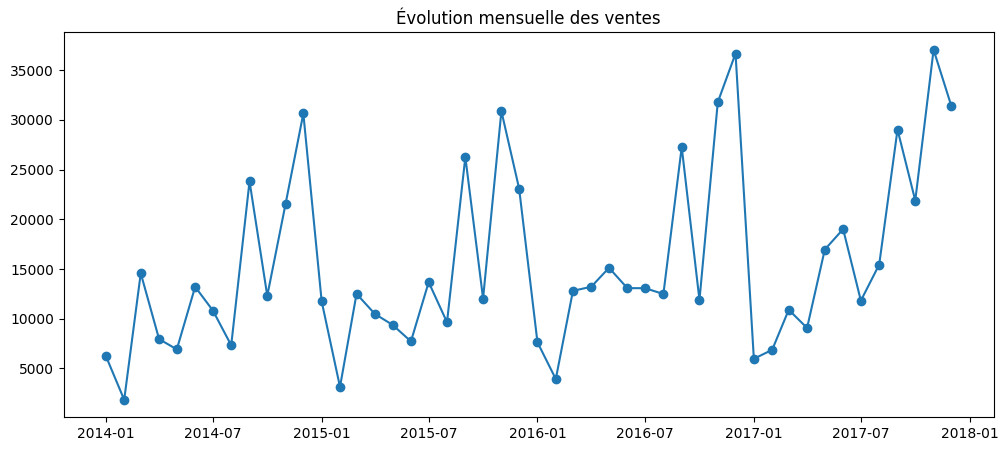

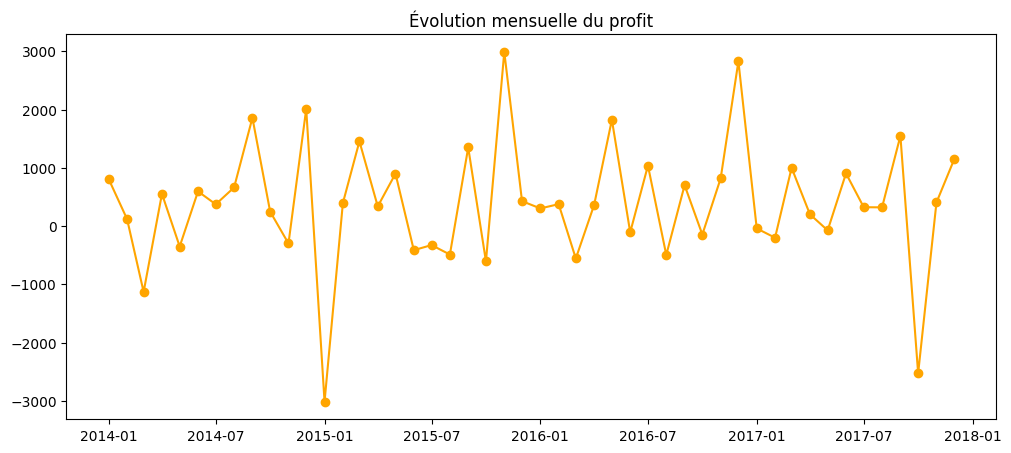

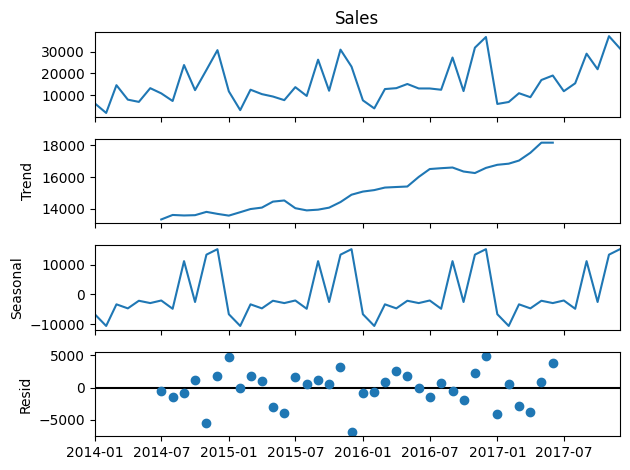

In [5]:
%matplotlib inline

# Profiling
profile_full = ProfileReport(
    df,
    title="EDA - Superstore Sales (full, toutes colonnes)",
    explorative=True
)
profile_full.to_file("../reports/eda_report.html")
print("✅ Rapport complet généré : ../reports/eda_report.html")

# Distribution des ventes
plt.figure(figsize=(8,5))
sns.histplot(df["Sales"], bins=50, kde=True)
plt.title("Distribution des ventes")
plt.show()

# Courbe interactive des ventes par date
df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")
sales_time = df.groupby("Order Date")["Sales"].sum().reset_index()

fig = px.line(sales_time, x="Order Date", y="Sales", 
              title="Évolution des ventes dans le temps")
fig.show()

# Vérification de la saisonnalité

# Extraire année et mois
df["Order_Year"] = df["Order Date"].dt.year
df["Order_Month"] = df["Order Date"].dt.month

# Agrégation mensuelle
monthly_sales = df.groupby(['Order_Year','Order_Month'])['Sales'].sum().reset_index()
monthly_sales['Date'] = pd.to_datetime(
    monthly_sales['Order_Year'].astype(str) + '-' + monthly_sales['Order_Month'].astype(str) + '-01'
)

monthly_profit = df.groupby(['Order_Year','Order_Month'])['Profit'].sum().reset_index()
monthly_profit['Date'] = pd.to_datetime(
    monthly_profit['Order_Year'].astype(str) + '-' + monthly_profit['Order_Month'].astype(str) + '-01'
)

# Plots
plt.figure(figsize=(12,5))
plt.plot(monthly_sales['Date'], monthly_sales['Sales'], marker='o')
plt.title("Évolution mensuelle des ventes")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(monthly_profit['Date'], monthly_profit['Profit'], marker='o', color='orange')
plt.title("Évolution mensuelle du profit")
plt.show()

# Décomposition
monthly_sales = monthly_sales.set_index('Date')
decomposition = seasonal_decompose(monthly_sales['Sales'], model='additive', period=12)  
decomposition.plot()
plt.show()

**Note** : La barre de progression avec *ydata-profiling* ne monte pas toujours à 100%. C’est normal car certaines étapes du traitement terminent rapidement, mais le rapport est bien généré et complet dans reports/eda_report.html.

### Constat

- La distribution des ventes démontrent qu'il y a des outliers dont il faudra tenir compte.

- La décomposition de la série temporelle des ventes montre :

    - une tendance croissance des ventes sur 2014–2017 (exemple de causes : expansion de la business, plus de clients/produits).

    - une saisonnalité à cause des pics récurrents et avec un pattern (ex: promotions, événements saisonniers, fin d’année).

### Prochaines étapes 
- Comme une saisonnalité est détectée, je vais ajouter des features temporels (ex. : mois, trimestre, période promotionnelle).  
- Pour une modélisation avancée, on pourrait envisager des modèles spécialisés en séries temporelles (ex: LSTM), mais pour l'objectif actuel du projet, je vais simplement enrichir le dataset avec des features temporels.

# 1. Modèle de Classification : Prédire la profitabilité d'une commande
### Feature Engineering et Sélection
Je choisis d'abord XGBoostClassifier comme modèle car il est réputé pour bien performer.

is_profitable
1    0.647808
0    0.352192
Name: proportion, dtype: float64
             Sales     Discount
count  2121.000000  2121.000000
mean    349.834887     0.173923
std     503.179145     0.181547
min       1.892000     0.000000
25%      47.040000     0.000000
50%     182.220000     0.200000
75%     435.168000     0.300000
max    4416.174000     0.700000


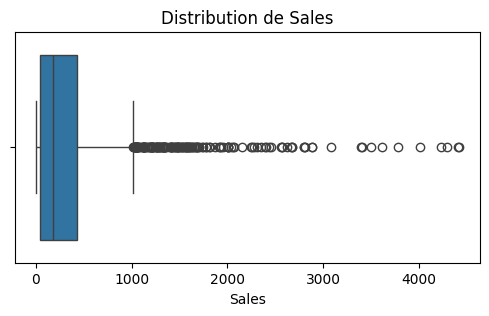

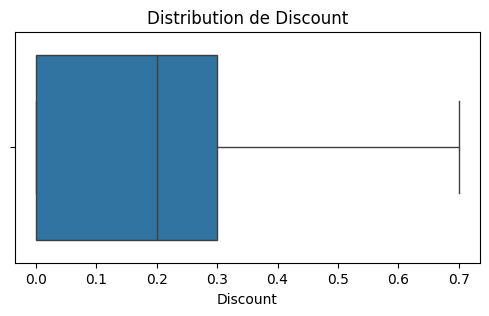

✅ Dataset prétraité sauvegardé dans ../data/interim/stores_sales_forecasting_interim.csv
              precision    recall  f1-score   support

           0       0.91      0.79      0.84       150
           1       0.89      0.96      0.92       275

    accuracy                           0.90       425
   macro avg       0.90      0.87      0.88       425
weighted avg       0.90      0.90      0.89       425



In [6]:
# Créer la variable cible (classification binaire : profitable ou non)
df['is_profitable'] = (df['Profit'] > 0).astype(int)

# Vérif rapide de la distribution de la cible
print(df['is_profitable'].value_counts(normalize=True))

# Distribution des features numériques
print(df[['Sales', 'Discount']].describe())

# Boxplots pour repérer les outliers
for col in ['Sales', 'Discount']:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df[col])
    plt.title(f"Distribution de {col}")
    plt.show()

# Conversion des dates
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], errors='coerce')

# Extraction de nouvelles features temporelles
df['Order_DayOfWeek'] = df['Order Date'].dt.dayofweek
df['Order_Quarter'] = df['Order Date'].dt.quarter
df['Is_EndOfYear'] = (df['Order_Month'] == 12).astype(int)   # période de fin d’année
df['Delivery_Days'] = (df['Ship Date'] - df['Order Date']).dt.days

# Sélection des features (numériques + catégoriels)
num_features = [
    'Sales','Discount','Order_Year','Order_Month',
    'Order_DayOfWeek','Order_Quarter','Is_EndOfYear','Delivery_Days'
]

cat_features = [
    'Ship Mode','Segment','City','Region','Sub-Category','State','Product ID','Customer ID'
]

features = df[num_features + cat_features]

# Sauvegarde du dataset transformé dans data/processed
processed_path = "../data/interim/stores_sales_forecasting_interim.csv"

df_processed = df[num_features + cat_features + ['is_profitable']].copy()
df_processed.to_csv(processed_path, index=False)

print(f"✅ Dataset prétraité sauvegardé dans {processed_path}")

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    features, df['is_profitable'], 
    test_size=0.2, random_state=42, stratify=df['is_profitable']
)

# Preprocessing : OneHotEncoder pour les catégoriels
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
], remainder="passthrough")

# Pipeline avec XGBoostClassifier
clf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(eval_metric="logloss", random_state=42))
])

# Entraînement
clf.fit(X_train, y_train)

# Évaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


### Analyse des résultats et décisions

- Distribution de la cible: 65% des transactions sont profitables contre 35% non profitables. Légère asymétrie mais pas problématique. Si la proportion profitable/non-profitable avait été très déséquilibrée, on aurait pu utiliser SMOTE ou ajuster scale_pos_weight dans XGBoost pour rebalancer les classes.
- Performance du modèle (XGBoost) : accuracy ≈ 90%, F1-score ≈ 0.84 (non profitable) et 0.92 (profitable). Le modèle distingue bien les cas rentables.  
- Analyse des features :
  - `Sales` contient de forts outliers. Je vais faire une transformation logarithmique pour stabiliser la variance lors de la regression.  
  - `Discount` montre des effets non linéaires. Certains gros discounts pourraient expliquer les ventes non-profitables, mais je ne pousse pas plus loin car ce n'est pas l'objectif du projet.

### Prochaine étape  
- Explorer l’importance des features pour mieux comprendre leurs effets sur la profitabilité.  

## Importance des variables : Pour explicabilité du modèle

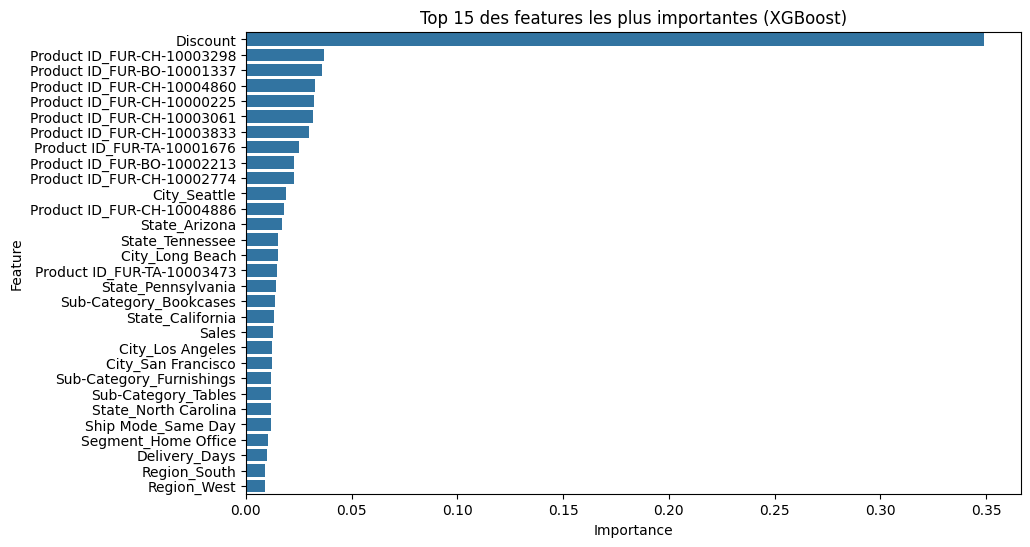

                         Feature  Importance
1451                    Discount    0.349007
503   Product ID_FUR-CH-10003298    0.036980
408   Product ID_FUR-BO-10001337    0.036215
532   Product ID_FUR-CH-10004860    0.032589
452   Product ID_FUR-CH-10000225    0.032430
501   Product ID_FUR-CH-10003061    0.031645
513   Product ID_FUR-CH-10003833    0.029817
729   Product ID_FUR-TA-10001676    0.025278
419   Product ID_FUR-BO-10002213    0.022928
496   Product ID_FUR-CH-10002774    0.022671
295                 City_Seattle    0.018915
534   Product ID_FUR-CH-10004886    0.018143
355                State_Arizona    0.017098
393              State_Tennessee    0.015083
172              City_Long Beach    0.014987
755   Product ID_FUR-TA-10003473    0.014841
389           State_Pennsylvania    0.014096
350       Sub-Category_Bookcases    0.013973
357             State_California    0.013371
1450                       Sales    0.013009
176             City_Los Angeles    0.012409
287       

In [7]:
# Récupérer les noms des features après OneHotEncoding
ohe = clf.named_steps["preprocessor"].named_transformers_["cat"]
ohe_features = ohe.get_feature_names_out(cat_features)
all_features = np.concatenate([ohe_features, num_features])

# Récupérer les importances
importances = clf.named_steps["model"].feature_importances_

# Construire un dataframe trié
feat_importances = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Afficher le top 15
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_importances.head(30))
plt.title("Top 15 des features les plus importantes (XGBoost)")
plt.show()

print(feat_importances.head(30))

### Constat

Discount et Product ID sont les features les plus explicatifs de la profitabilité. Certains `State` comme Seattle, Arizona, Tennessee ont un poids non négligeable (peut-être pour des raisons comme coûts logistiques, comportement client, etc). Les autres variables ont un impact marginal.  

XGBoost gère naturellement les variables moins pertinentes, alors je conserve tous les features pour la suite, mais je retiens que les rabais, le type de produit et certaines zones géographiques sont les principaux features explicatifs de la profitabilité.

## Conclusion Classification
La classification des transactions permet de cibler les ventes rentables.  L'étape suivante est de construire un modèle de régression sur les ventes profitables.  

C'est une approche qui me semble cohérente pour point de vue business. Je vais entraîner un modèle de régression uniquement sur les ventes profitables afin de prédire le montant des ventes futures qui sont pertinentes (i.e. avec profit > 0). Cette approche permet aux gestionnaires de prendre de meilleures décisions quant aux ventes futures, rabais actuels, logistique de livraison, etc.

# 2. Régression conditionnelle: prédire le montant des ventes seulement pour les transactions profitables

Train - MAE: 107.53, RMSE: 148.07
Test  - MAE: 226.79, RMSE: 399.78


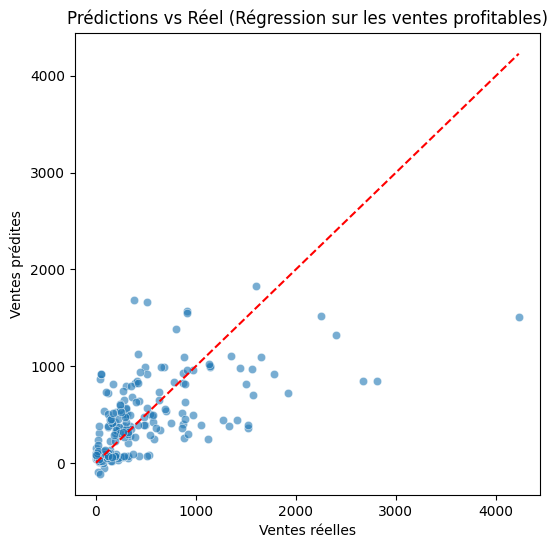

In [8]:
# Filtrer uniquement les transactions profitables
df_profitable = df[df['is_profitable'] == 1].copy()

# Features identiques à la classification
num_features_reg = [
    'Discount','Order_Year','Order_Month',
    'Order_DayOfWeek','Order_Quarter','Is_EndOfYear','Delivery_Days'
]

cat_features_reg = [
    'Ship Mode','Segment','City','Region','Sub-Category','State','Product ID','Customer ID'
]

# Définir X et y
X_reg = df_profitable[num_features_reg + cat_features_reg].copy()
y_reg = df_profitable['Sales']

# Split train/test
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg,
    test_size=0.2, random_state=42
)

# Préprocessing
preprocessor_reg = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features_reg)
], remainder="passthrough")

# Pipeline avec XGBRegressor
reg = Pipeline([
    ("preprocessor", preprocessor_reg),
    ("model", XGBRegressor(
        n_estimators=300, 
        learning_rate=0.1, 
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

# Entraînement
reg.fit(X_train_reg, y_train_reg)

# Évaluation sur test set
y_pred_test = reg.predict(X_test_reg)

# Scores TRAIN
y_pred_train = reg.predict(X_train_reg)
mae_train = mean_absolute_error(y_train_reg, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train_reg, y_pred_train))

# Scores TEST
mae_test = mean_absolute_error(y_test_reg, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test_reg, y_pred_test))

print(f"Train - MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}")
print(f"Test  - MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}")

# Courbe prédictions vs valeurs réelles
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test_reg, y=y_pred_test, alpha=0.6)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
plt.xlabel("Ventes réelles")
plt.ylabel("Ventes prédites")
plt.title("Prédictions vs Réel (Régression sur les ventes profitables)")
plt.show()

### Constat 

- Le modèle capte la tendance générale, il a du mal avec les outliers. Je vais appliquer une transformation log.

### Prochaine étape

- Tester une transformation log(Sales) pour réduire l’influence des outliers sur la loss function RMSE/MSE.
- Envisager d'autres modèles si les résultats ne sont pas satisfaisant.

## Log-Transform

Train - MAE: 132.68, RMSE: 301.71
Test  - MAE: 201.28, RMSE: 422.69


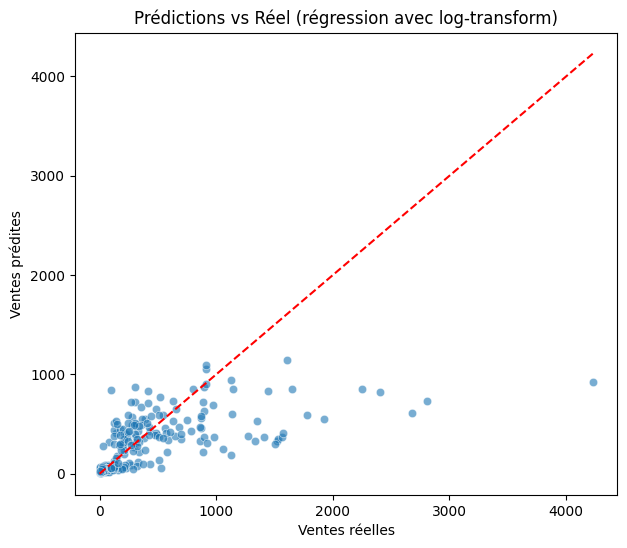

,Modèle,MAE,RMSE
0,XGBoost (sans log-transform),226.79,399.78
1,XGBoost (log-transform),201.28,422.69


In [9]:
# Cible avec transformation log sur le split unique
y_train_log = np.log1p(y_train_reg)
y_test_log  = np.log1p(y_test_reg)

# Entraînement sur X_train_reg et y_train_log
reg.fit(X_train_reg, y_train_log)

# Prédictions TEST 
y_pred_test_log = reg.predict(X_test_reg)            # prédictions en log
y_pred_test = np.expm1(y_pred_test_log)              # inverse du log -> ventes réelles
y_test_real = y_test_reg.values                      # ventes réelles

# Prédictions TRAIN
y_pred_train_log = reg.predict(X_train_reg)
y_pred_train = np.expm1(y_pred_train_log)
y_train_real = y_train_reg.values

# Scores TRAIN
mae_train = mean_absolute_error(y_train_real, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train_real, y_pred_train))

# Scores TEST
mae_default = mean_absolute_error(y_test_real, y_pred_test)
rmse_default = np.sqrt(mean_squared_error(y_test_real, y_pred_test))

print(f"Train - MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}")
print(f"Test  - MAE: {mae_default:.2f}, RMSE: {rmse_default:.2f}")

# Scatter plot
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test_real, y=y_pred_test, alpha=0.6)
plt.plot([0, max(y_test_real)], [0, max(y_test_real)], color="red", linestyle="--")
plt.xlabel("Ventes réelles")
plt.ylabel("Ventes prédites")
plt.title("Prédictions vs Réel (régression avec log-transform)")
plt.show()


results = pd.DataFrame([
    {"Modèle": "XGBoost (sans log-transform)", "MAE": round(mae_test, 2), "RMSE": round(rmse_test, 2)},
    {"Modèle": "XGBoost (log-transform)",   "MAE": round(mae_default, 2),     "RMSE": round(rmse_default, 2)}
])
display(results)

### Constat

Avec log-transform, les prédictions sont mieux centrées pour les petites et moyennes ventes, mais les grosses ventes sont sous-estimées (MAE diminue mais RMSE augmente).

### Décision 
- Conserver l'approche log-transform pour la modélisation des ventes profitables pour privilégier l’objectif de minimiser les erreurs relatives pour la majorité des ventes (robustesse globale).
- Dans un cas réel, je testerais d'autres modèles (ex: linéaires ou RandomForest), mais je me limite à XGBoost pour le home assignment et je vais l'optimiser.
- Je vais tout de même comparer à une baseline pour m'assurer que XBoost est meilleur.

### Prochaines étapes
- Comparaison XGBoost avec baseline
- Tuning et plus de Features
- Valider la robustesse via cross-validation. 

## Baseline Model (pred = moyenne des ventes du train set)

In [10]:
baseline_pred = np.repeat(y_train_real.mean(), len(y_test_real))
mae_baseline = mean_absolute_error(y_test_real, baseline_pred)
rmse_baseline = np.sqrt(mean_squared_error(y_test_real, baseline_pred))
results = pd.DataFrame([
    {"Modèle": "Baseline (mean predictor)", "MAE": round(mae_baseline, 2), "RMSE": round(rmse_baseline, 2)},
    {"Modèle": "XGBoost (log-transform)",   "MAE": round(mae_default, 2),     "RMSE": round(rmse_default, 2)}
])
display(results)

,Modèle,MAE,RMSE
0,Baseline (mean predictor),339.94,529.86
1,XGBoost (log-transform),201.28,422.69


### Constat
XGBoost reste meilleur que baseline alors on le garde.

### Prochaine étape
Je vais tuner les hyperparameter de modèle sur certains ranges et appliquer les meilleurs params au modèle.

## Tuning XGBoost

In [11]:
# Range recherche des hyperparamètres
param_dist = {
    "model__n_estimators": randint(100, 400),
    "model__max_depth": randint(2, 8),
    "model__learning_rate": uniform(0.01, 0.2),
    "model__subsample": uniform(0.6, 0.4),
    "model__colsample_bytree": uniform(0.6, 0.4),
    "model__reg_alpha": uniform(0, 1),   # L1
    "model__reg_lambda": uniform(1, 5),  # L2
}

# RandomizedSearchCV = recherche aléatoire dans l’espace des hyperparamètres
search = RandomizedSearchCV(
    reg, param_distributions=param_dist,
    n_iter=30, scoring="neg_root_mean_squared_error",
    cv=3, verbose=1, random_state=42, n_jobs=-1
)

# Entraînement (avec cible en log)
search.fit(X_train_reg, y_train_log)

print("Best params:", search.best_params_)
print("Best CV score (log-space RMSE):", -search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params: {'model__colsample_bytree': np.float64(0.8783251227163527), 'model__learning_rate': np.float64(0.18167176096274398), 'model__max_depth': 5, 'model__n_estimators': 246, 'model__reg_alpha': np.float64(0.3486659872917294), 'model__reg_lambda': np.float64(1.4808827554571038), 'model__subsample': np.float64(0.9762093057958416)}
Best CV score (log-space RMSE): 0.9674212181430715


In [12]:
# Hyperparamètres optimisés
best_params = {
    "n_estimators": 246,
    "learning_rate": 0.18,
    "max_depth": 5,
    "subsample": 0.976,
    "colsample_bytree": 0.698,
    "reg_alpha": 0.349,
    "reg_lambda": 1.48,
    "random_state": 42
}

# Pipeline avec préprocessing + modèle XGBRegressor optimisé
reg_tuned = Pipeline([
    ("preprocessor", preprocessor_reg),
    ("model", XGBRegressor(**best_params))
])

# Entraînement sur split unique avec target log-transformée
reg_tuned.fit(X_train_reg, y_train_log)

# Évaluation sur le test set
y_pred_test_log = reg_tuned.predict(X_test_reg)   # prédictions en log
y_pred_test = np.expm1(y_pred_test_log)           # retour en ventes réelles
y_test_real = y_test_reg.values                   # vraies ventes réelles

# Calcul des métriques d’erreur
mae_tuned = mean_absolute_error(y_test_real, y_pred_test)
rmse_tuned = np.sqrt(mean_squared_error(y_test_real, y_pred_test))

# Construire un tableau récapitulatif des modèles et scores
results = pd.DataFrame([
    {"Modèle": "Baseline (mean predictor)", "MAE": round(mae_baseline, 2), "RMSE": round(rmse_baseline, 2)},
    {"Modèle": "XGBoost (défaut)",          "MAE": round(mae_default, 2),  "RMSE": round(rmse_default, 2)},
    {"Modèle": "XGBoost (tuné)",            "MAE": round(mae_tuned, 2),    "RMSE": round(rmse_tuned, 2)}
])

display(results)

# Moyenne des ventes (Sales) pour les transactions profitables
mean_sales_profitable = df[df['is_profitable'] == 1]['Sales'].mean()
print(f"Moyenne des ventes profitables : {mean_sales_profitable:.2f}")

,Modèle,MAE,RMSE
0,Baseline (mean predictor),339.94,529.86
1,XGBoost (défaut),201.28,422.69
2,XGBoost (tuné),197.43,419.31


Moyenne des ventes profitables : 338.51


### Constat
- Le modèle tuné est lêgèrement meilleur alors on le conserve

### Prochaine étape
Je vais encore essayer d'améliorer le modèle en ajoutant des features plus avancés.

## Features avancés

In [13]:
# Filtrer uniquement les transactions profitables
df_reg = df[df['is_profitable'] == 1].copy()

# Feature 1 : cyclicité 
df_reg["DayOfWeek_sin"] = np.sin(2 * np.pi * df_reg["Order_DayOfWeek"] / 7)
df_reg["DayOfWeek_cos"] = np.cos(2 * np.pi * df_reg["Order_DayOfWeek"] / 7)

df_reg["Month_sin"] = np.sin(2 * np.pi * df_reg["Order_Month"] / 12)
df_reg["Month_cos"] = np.cos(2 * np.pi * df_reg["Order_Month"] / 12)

df_reg["Quarter_sin"] = np.sin(2 * np.pi * df_reg["Order_Quarter"] / 4)
df_reg["Quarter_cos"] = np.cos(2 * np.pi * df_reg["Order_Quarter"] / 4)

# Feature 2 : moyennes groupées
df_reg['State_Avg_Sales'] = df_reg.groupby('State')['Sales'].transform('mean')
df_reg['Category_Avg_Sales'] = df_reg.groupby('Sub-Category')['Sales'].transform('mean')

# Feature 3 : flag high discount 
df_reg['High_Discount'] = (df_reg['Discount'] > 0.3).astype(int)

# Reconstruire X avec les nouvelles colonnes
base_features = [
    f for f in num_features_reg
    if f not in ['Order_DayOfWeek', 'Order_Month', 'Order_Quarter', 'Order_Year']
]

X_reg_features = df_reg[
    base_features + cat_features_reg +
    [
        'State_Avg_Sales', 'Category_Avg_Sales', 'High_Discount',
        'DayOfWeek_sin','DayOfWeek_cos',
        'Month_sin','Month_cos',
        'Quarter_sin','Quarter_cos'
    ]
]
y_reg = df_reg['Sales']

processed_path = "../data/processed/stores_sales_forecasting_processed.csv"
df_reg.to_csv(processed_path, index=False)
print(f"✅ Dataset enrichi exporté dans {processed_path}")

# On ne refait PAS de split, on réutilise les indices du split unique
X_train_features = X_reg_features.loc[X_train_reg.index]
X_test_features  = X_reg_features.loc[X_test_reg.index]
y_train_features = np.log1p(y_train_reg)   # cible en log pour entraînement
y_test_real = y_test_reg.values            # valeurs réelles pour évaluation


# Réentraîner le modèle avec features avancées
reg_tuned.fit(X_train_features, y_train_features)

# Prédictions TEST
y_pred_test_log = reg_tuned.predict(X_test_features)
y_pred_test = np.expm1(y_pred_test_log)

# Scores
mae_test_features = mean_absolute_error(y_test_real, y_pred_test)
rmse_test_features = np.sqrt(mean_squared_error(y_test_real, y_pred_test))

# Construire un tableau récapitulatif des modèles et scores
results = pd.DataFrame([
    {"Modèle": "Baseline (mean predictor)", "MAE": round(mae_baseline, 2), "RMSE": round(rmse_baseline, 2)},
    {"Modèle": "XGBoost (défaut)",          "MAE": round(mae_default, 2),     "RMSE": round(rmse_default, 2)},
    {"Modèle": "XGBoost (tuné)",            "MAE": round(mae_tuned, 2),          "RMSE": round(rmse_tuned, 2)},
    {"Modèle": "XGBoost (tuné + features)", "MAE": round(mae_test_features, 2),          "RMSE": round(rmse_test_features, 2)}
])

display(results)

✅ Dataset enrichi exporté dans ../data/processed/stores_sales_forecasting_processed.csv


,Modèle,MAE,RMSE
0,Baseline (mean predictor),339.94,529.86
1,XGBoost (défaut),201.28,422.69
2,XGBoost (tuné),197.43,419.31
3,XGBoost (tuné + features),200.91,421.51


### Constat
- Très proche du modèle seulement tuné, légèrement moins bon, donc les features avancées n’apportent pas de valeur significative (elles introduisent probablement du bruit ou de la redondance). Je conserve donc le modèle XGBoost (tuné).
- Les prédictions s’écartent en moyenne d’environ 200 $ des ventes réelles par transaction; c'est beaucoup considérant une moyenne d'environ 339 par vente profitable.

### Décision
Pour ce projet, je m’arrête à ce stade, mais dans une situation réelle, j’aurais poursuivi l’analyse en testant d’autres types de modèles et en faisant davantage de tuning et test de features. 

### Prochaine étape
Pour la suite, je vais supposer que le modèle est satisfaisant et je vais faire: 
- cross-validation pour assurer la robustesse du modèle

In [24]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.compose._column_transformer")

# Réentraînement sur les données de base (sans features avancées) (J'aurais du definir plusieurs pipeline au départ pour ne pas avoir à réentrainer...)
reg_tuned.fit(X_train_reg, y_train_log)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Ship Mode', 'Segment',
                                                   'City', 'Region',
                                                   'Sub-Category', 'State',
                                                   'Product ID',
                                                   'Customer ID'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytr...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.18,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=246, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

## Cross-Validation

In [15]:
# Sélectionner seulement les transactions profitables
df_reg = df[df['is_profitable'] == 1].copy()

# Variables numériques et catégorielles
num_features = [
    'Discount','Order_Year','Order_Month',
    'Order_DayOfWeek','Order_Quarter','Is_EndOfYear','Delivery_Days'
]

cat_features = [
    'Ship Mode','Segment','City','Region','Sub-Category','State','Product ID','Customer ID'
]

X_reg = df_reg[num_features + cat_features]
y_reg = df_reg['Sales']

# Transformation log sur la cible
log_y = np.log1p(y_reg)

# Preprocessing (OneHotEncoder pour les catégorielles)
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
], remainder="passthrough")

# Pipeline XGBoost (hyperparamètres tunés)
reg = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(**best_params))
])


# Custom scorers en valeurs réelles
def rmse_real(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)   # revenir à l’échelle réelle
    y_pred = np.expm1(y_pred_log)
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae_real(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return mean_absolute_error(y_true, y_pred)

rmse_scorer = make_scorer(rmse_real, greater_is_better=False)
mae_scorer = make_scorer(mae_real, greater_is_better=False)


# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = -cross_val_score(reg, X_reg, log_y, cv=kf, scoring=rmse_scorer)
mae_scores  = -cross_val_score(reg, X_reg, log_y, cv=kf, scoring=mae_scorer)

print("Cross-validation RMSE (réel) par fold :", rmse_scores)
print("RMSE moyen (réel):", rmse_scores.mean())
print("RMSE écart-type (réel):", rmse_scores.std())

print("\nCross-validation MAE (réel) par fold :", mae_scores)
print("MAE moyen (réel):", mae_scores.mean())
print("MAE écart-type (réel):", mae_scores.std())

Cross-validation RMSE (réel) par fold : [423.81890702 434.63394269 400.81837279 372.21144885 517.04333247]
RMSE moyen (réel): 429.7052007646418
RMSE écart-type (réel): 48.63511188427577

Cross-validation MAE (réel) par fold : [199.82767359 211.72357065 192.91979312 176.16226074 234.58485936]
MAE moyen (réel): 203.0436314904733
MAE écart-type (réel): 19.522463889807103


### Constat
MAE moyen de 203 avec ecart-type de 19.5, donc stabilité satisfaisante d’un échantillon à l’autre. 
### Prochaine étape
- analyser les courbes d’apprentissage
- intégrer early stopping pour prevenir overfitting et optimiser le temps d’entraînement

## Suivi des courbes d’apprentissage et early stopping

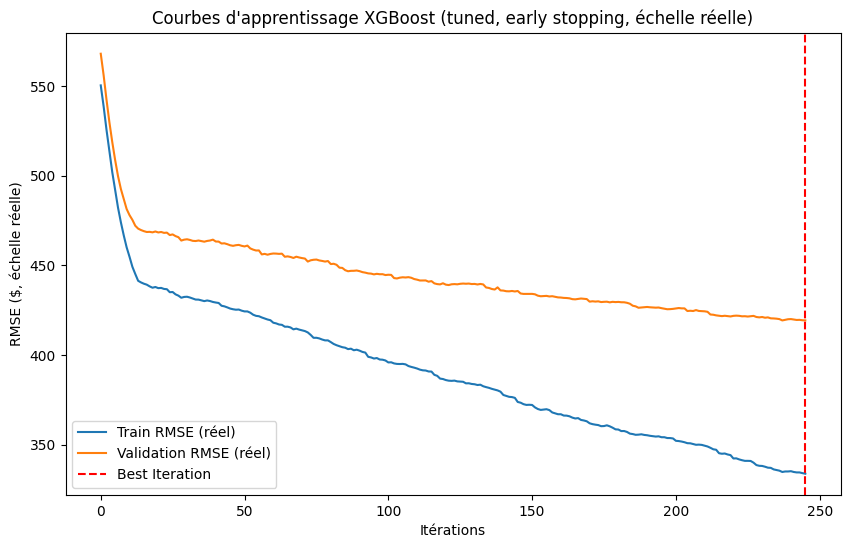

In [16]:
# Transformer explicitement les données avec le preprocessor
X_train_enc = preprocessor_reg.fit_transform(X_train_reg)
X_test_enc  = preprocessor_reg.transform(X_test_reg)

# Conversion en DMatrix
dtrain = DMatrix(X_train_enc, label=np.log1p(y_train_reg))
dvalid = DMatrix(X_test_enc, label=np.log1p(y_test_reg))

# Paramètres
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",  # reste en log-space ici
    "eta": best_params["learning_rate"],    
    "max_depth": best_params["max_depth"],
    "subsample": best_params["subsample"],
    "colsample_bytree": best_params["colsample_bytree"],
    "reg_alpha": best_params["reg_alpha"],
    "reg_lambda": best_params["reg_lambda"],
    "seed": best_params["random_state"]
}

num_boost_round = best_params["n_estimators"]
evals_result = {}

# Entraînement avec early stopping
xgb_model = train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=20,
    evals_result=evals_result,
    verbose_eval=False
)

# Calcul des RMSE en échelle réelle
train_rmse_real, valid_rmse_real = [], []
y_train_real = y_train_reg.values
y_valid_real = y_test_reg.values

n_rounds = len(evals_result["train"]["rmse"])

for i in range(1, n_rounds + 1):
    # prédictions log
    y_pred_train_log = xgb_model.predict(dtrain, iteration_range=(0, i))
    y_pred_valid_log = xgb_model.predict(dvalid, iteration_range=(0, i))
    
    # retour en échelle réelle
    y_pred_train = np.expm1(y_pred_train_log)
    y_pred_valid = np.expm1(y_pred_valid_log)
    
    # RMSE réels
    rmse_train = np.sqrt(mean_squared_error(y_train_real, y_pred_train))
    rmse_valid = np.sqrt(mean_squared_error(y_valid_real, y_pred_valid))
    
    train_rmse_real.append(rmse_train)
    valid_rmse_real.append(rmse_valid)

# Visualisation
plt.figure(figsize=(10,6))
plt.plot(train_rmse_real, label="Train RMSE (réel)")
plt.plot(valid_rmse_real, label="Validation RMSE (réel)")
plt.axvline(xgb_model.best_iteration, color="red", linestyle="--", label="Best Iteration")
plt.xlabel("Itérations")
plt.ylabel("RMSE ($, échelle réelle)")
plt.title("Courbes d'apprentissage XGBoost (tuned, early stopping, échelle réelle)")
plt.legend()
plt.show()

### Constat
- Forte baisse initiale du RMSE: les patterns principaux sont appris rapidement.  
- Ensuite, diminution plus progressive: raffinement.  
- Les courbes train/validation restent proches, sans trop de divergence: pas de overfitting.  
### Early Stopping

In [17]:
# Prédictions avec le meilleur nombre d'itérations
best_iter = xgb_model.best_iteration
y_pred_train_log = xgb_model.predict(dtrain, iteration_range=(0, best_iter + 1))
y_pred_test_log  = xgb_model.predict(dvalid, iteration_range=(0, best_iter + 1))

# Retour à l’échelle réelle
y_pred_train = np.expm1(y_pred_train_log)
y_pred_test  = np.expm1(y_pred_test_log)

# Les y réels sont ceux d’origine (en $), pas log-transformés
y_train_real = y_train_reg.values
y_test_real  = y_test_reg.values

# Scores en échelle réelle
mae_train = mean_absolute_error(y_train_real, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train_real, y_pred_train))

mae_test = mean_absolute_error(y_test_real, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test_real, y_pred_test))

print(f"✅ MAE train (réel): {mae_train:.2f}")
print(f"✅ RMSE train (réel): {rmse_train:.2f}")
print(f"✅ MAE test  (réel): {mae_test:.2f}")
print(f"✅ RMSE test (réel): {rmse_test:.2f}")

✅ MAE train (réel): 144.88
✅ RMSE train (réel): 333.70
✅ MAE test  (réel): 197.43
✅ RMSE test (réel): 419.31


# Exporter le modèle

In [18]:
# Sauvegarde pipeline de classification
clf_path = "../models/classifier_pipeline.joblib"
joblib.dump(clf, clf_path)
print(f"✅ Pipeline de classification sauvegardé dans {clf_path}")

# Sauvegarde pipeline de régression
reg_path = "../models/regressor_pipeline.joblib"
joblib.dump(reg_tuned, reg_path)
print(f"✅ Pipeline de régression sauvegardé dans {reg_path}")

✅ Pipeline de classification sauvegardé dans ../models/classifier_pipeline.joblib
✅ Pipeline de régression sauvegardé dans ../models/regressor_pipeline.joblib


## Test pour charger et utiliser le modèle
5 premieres predictions de mon test set

In [19]:
# === 2. RECHARGEMENT ===
loaded_clf = joblib.load("../models/classifier_pipeline.joblib")
loaded_reg = joblib.load("../models/regressor_pipeline.joblib")

print("✅ Modèles rechargés avec succès")

✅ Modèles rechargés avec succès


In [20]:
# prédire la profitabilité
y_pred_class = loaded_clf.predict(X_test)

# filtrer les commandes profitables
mask_profitable = (y_pred_class == 1)

# reconstruire X_test au bon format XGB tuné simple (sans features avancées)
X_test_reg = X_test[num_features_reg + cat_features_reg].copy()

# Filtrer les profitables
X_test_profitable = X_test_reg.loc[y_pred_class == 1]

# Appliquer la régression
y_pred_sales_log = loaded_reg.predict(X_test_profitable)
y_pred_sales = np.expm1(y_pred_sales_log)

print("✅ Exemple de ventes prédites (5 premières) :", y_pred_sales[:5])

✅ Exemple de ventes prédites (5 premières) : [114.860466 390.51102  873.01917  750.03      81.42805 ]


# Conclusion

L'approche en deux étapes permet d’apporter une aide concrète aux gestionnaires :

1. **Classification (XGBoost binaire)**  
   - Prédiction de la profitabilité d’une commande avec une précision globale de ~90%.  
   - Les features les plus influents sont Discount, le type de produit et la zone géographique.

2. **Régression (XGBoost sur transactions profitables)**
   - Modèle XGBoost retenu avec tuning des hyperparamètres
   - L'ajout de features avancés a été testé mais sans amélioration significatives, donc les features non pas été retenus
   - Prédiction des ventes avec une performance plus ou moins bonne considérant une moyenne de 339$ par vente profitable:  
     - **RMSE ≈ 419**  
     - **MAE ≈ 197**  
   - La courbe d’apprentissage confirme un apprentissage rapide des principaux patterns et l’absence d'overfitting.
   - Early stopping implémenté

**Valeur ajoutée pour la business** :  
- Identifier à l’avance les commandes à risque de non-profitabilité.  
- Estimer le montant attendu des ventes profitables, même dans un contexte de forte variabilité.  
- Ces insights peuvent orienter des décisions sur les stratégies de rabais, d'inventaires et de logistique.